# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

from gensim.models import CoherenceModel
import gensim.corpora as corpora
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews_list = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    results = soup.find_all("article", attrs={"itemprop":"review"})
    for i in results:
        review_stats = {}
        rating = int(i.find("span",{"itemprop":"ratingValue"}).text)
        header = i.find("h2").text.replace("\"","")
        verified = i.strong.a.em.text
        review = i.find("div",class_="text_content").text.split("|")[1].replace("undefined","").strip()

        all_tr = i.find_all("tr")

        review_stats['Verified'] = verified
        review_stats['Header'] = header
        review_stats['Review'] = review
        review_stats['Rating'] = rating

        for tr in all_tr:
            values = tr.find_all("td", class_="review-value")
            valuesx = tr.find_all("td", class_="review-rating-header")
            if len(values) > 0:
                value = values[0].text
                review_stats[valuesx[0].text]= value
            else:
                stars = len(tr.find_all("span",class_="fill"))
                header = tr.find("td",class_="review-rating-header").text
                review_stats[header]= stars

        reviews_list.append(review_stats)

    print(f"   ---> {len(reviews_list)} total reviews")

In [5]:
df = pd.DataFrame(reviews_list)

In [6]:
df.to_csv("data/BA_reviews.csv",index=False)

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

# Topic Modelling

In [7]:
df = pd.read_csv("data/BA_reviews.csv")

In [8]:
data = df.Review

In [9]:
data.values[101]

'BA cancelled my flight home to Heathrow on Dec 19th. On the face of it, that was sensible as the weather in Iceland was appalling. However, what was not acceptable was that the flight was cancelled only 4 hours before take off time by which time I was already struggling through dreadful driving conditions to get to the airport. I got nowhere near before the conditions became too bad. If they had taken advice they would have spared everyone the need to try and travel on roads that all ended up closed. I am now booked onto the flight on the 21st and downgraded for my sins. Having checked today, as I type they have not cancelled the flight on the 20th despite the road to Keflavík being closed! Do they not check these things? Any help from BA offered - not really.'

In [84]:
def get_Cv(model, df_column):
    topics = model.components_


    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df_column]

    # Create a gensim dictionary from the word count matrix
    dictionary = corpora.Dictionary(texts)

    # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [10]:
tokenized_data = [word_tokenize(doc.lower()) for doc in list(data.values)]

stop_words = set(stopwords.words('english'))

f_data = [[word for word in doc if word not in stop_words and word.isalpha()] for doc in tokenized_data]

In [11]:
dictionary = set([word for doc in f_data for word in doc])


vectorize = CountVectorizer(vocabulary=dictionary, max_df=0.95, min_df=2, stop_words='english')

doc_term_matrix = vectorize.fit_transform([" ".join(doc) for doc in f_data])

In [85]:
coherences = []
perplexities = []
range_topics = range(2, 7)
for i in tqdm(range_topics):
    lda = LatentDirichletAllocation(n_components=i,random_state=42,max_iter=200)
    lda.fit(Xtrain)
    coherence = get_Cv(lda, data)
    coherences.append(coherence) 

  0%|          | 0/5 [00:00<?, ?it/s]

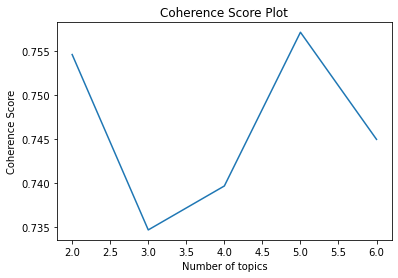

In [88]:
plt.plot(range_topics, coherences)
plt.title("Coherence Score Plot")
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score');

In [86]:
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42,max_iter=200)

In [87]:
lda.fit(doc_term_matrix)

LatentDirichletAllocation(max_iter=200, n_components=5, random_state=42)

In [89]:
num_top_words = 10
feature_names = vectorize.get_feature_names_out()
for topic_idx,topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1 : -1]]))

Topic #0
flight ba service london staff customer heathrow told cancelled airways
Topic #1
flight ba london hours delayed airport told arrived bags luggage
Topic #2
flight food ba seat crew service cabin class seats business
Topic #3
flight ba crew service cabin seats seat class time london
Topic #4
flight ba british airways seat refund airline travel service booked


## WordCloud

In [205]:
def word_cloud(num_words, topic_num):
    topic = lda.components_[topic_num]
    words = " ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1 : -1]])
    word_cloud = WordCloud(width=900,
                           height=200,
                           # font_path=font,
                           background_color='white',
                           stopwords=STOPWORDS
                          ).generate_from_text(words)
    figure = plt.figure(figsize=(15,5))
    plt.title(f"Top {num_words} words for topic {topic_num}")
    plt.imshow(word_cloud)
    plt.axis('off');

### Topic 0 Wordcloud

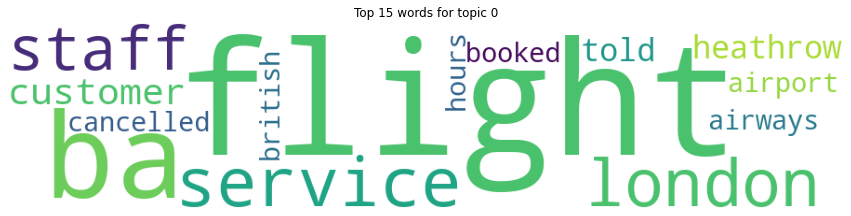

In [119]:
word_cloud(15, 0)

From the word cloud we can see that this topic is about the staff and customer service.

### Topic 1 Wordcloud

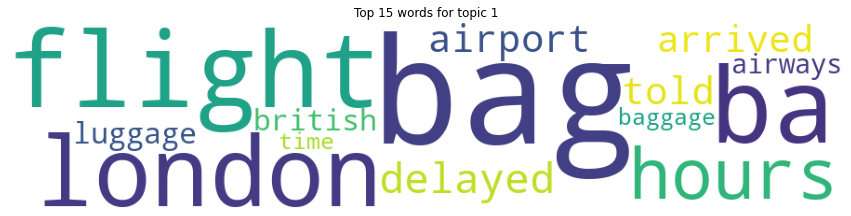

In [118]:
word_cloud(15, 1)

From the word cloud we can see that this topic is mostly about luggage.

### Topic 2 Wordcloud

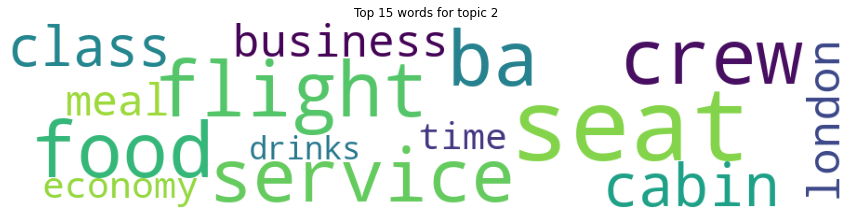

In [120]:
word_cloud(15, 2)

From the word cloud we can see that this topic is about food, drinks and entertainment .

### Topic 3 Wordcloud

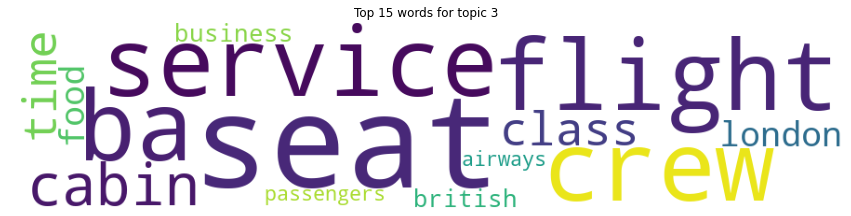

In [121]:
word_cloud(15, 3)

From the word cloud we can see that this topic is about the seats and cabin.

### Topic 4 Wordcloud

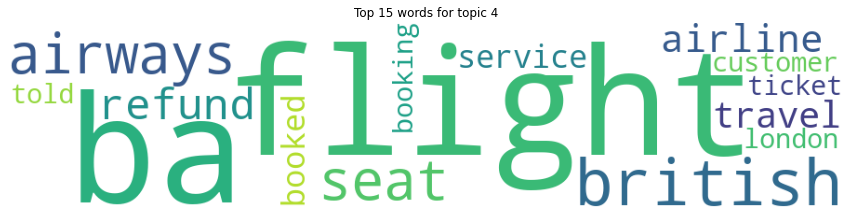

In [122]:
word_cloud(15, 4)

From the word cloud we can see that this topic is mostly about refunds, tickets and bookings.

### Group the reviews into predicted topics

In [102]:
topic_probabilities = lda.transform(doc_term_matrix)
sample_topics = [topic_probabilities[i].argsort() for i in range(len(data))]
topics_ = [i[-1] for i in sample_topics]
df["Predicted Topic"] = [f"Topic #{i}" for i in topics_]

In [123]:
for i in range(4):
    print(df["Predicted Topic"][i])
    print("*"*50)
    print(df["Review"][i])

Topic #3
**************************************************
I will never travel with British Airways again. I spent over $10,000 on a business class seat to attend a funeral in the UK. First, the Boeing 787-9 cabin has 7 seats across the aisle so what you are getting in reality is premium economy. The seats are narrow and effectively are a business class seat cut in half. They have squeezed these seats in which means that some passengers bump their heads into the bulkhead when they stand up and many have to clamber over others to go to the toilet, which wakes up that passenger. The whole point about business class is that you pay to rest and have privacy and not have someone push over the top of you. Second, the food was disgusting. Third, the service terrible. Fourth, the toilet was tiny. Fifth, the inflight screen was fixed and too high so I could not see anything. Sixth, their baggage handling is also appalling meaning that my taxi was waiting for 2 hours and I had to pay more (no f

# Sentiment Analysis

In [124]:
sia = SentimentIntensityAnalyzer()

## Get Sentiments

In [128]:
def get_sentiment_label(doc):
    score = sia.polarity_scores(doc)['compound']
    label = 'positive' if score > 0.5 else 'negative' if score < -0.5 else 'neutral'  
    return label

In [131]:
sentiments = [get_sentiment_label(i) for i in (data)]
df['review_sentiments'] = sentiments
df[df['review_sentiments'] == 'positive'].tail()

,Verified,Header,Review,Rating,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,review_sentiments,Predicted Topic
986,Trip Verified,gate staff should be better trained,Flew to Istanbul with British Airways on 5th J...,2,NaN,Couple Leisure,Economy Class,London to Istanbul,June 2018,3.0,3.0,1.0,1.0,1.0,NaN,2,no,positive,Topic #3
987,Trip Verified,crew welcoming and orderly,Munich to London Heathrow with British Airways...,7,A320,Solo Leisure,Economy Class,Munich to London Heathrow,July 2018,4.0,4.0,2.0,NaN,5.0,NaN,3,yes,positive,Topic #3
988,Trip Verified,Wonderful service,Wonderful service on the flight from Edinburgh...,10,NaN,Couple Leisure,Business Class,Edinburgh-Florence,July 2018,4.0,5.0,5.0,NaN,5.0,NaN,5,yes,positive,Topic #4
993,Trip Verified,it's not extra leg room,Pisa to London Heathrow. Having booked and pai...,1,A321,Couple Leisure,Economy Class,Pisa to London Heathrow,July 2018,1.0,3.0,NaN,NaN,3.0,NaN,2,no,positive,Topic #3
999,Trip Verified,always had a great experience,Mumbai to Edinburgh via London. I'm quite surp...,8,NaN,Solo Leisure,Premium Economy,Mumbai to Edinburgh via London,June 2018,5.0,5.0,3.0,4.0,5.0,NaN,5,yes,positive,Topic #2


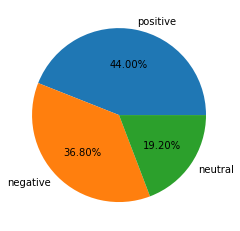

In [204]:
counts = df.review_sentiments.value_counts().reset_index()
plt.pie(counts.review_sentiments,labels=counts['index'],autopct='%.2f%%');
counts.to_csv('data/sentiments.csv',index=False)

## Sentiment By Topics

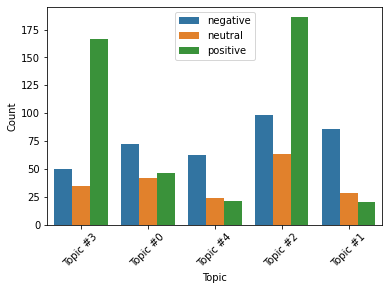

In [136]:
sns.countplot(x=df['Predicted Topic'], hue=sentiments)
plt.xticks(rotation=45)
plt.xlabel('Topic')
plt.ylabel('Count');

## Recommendation Analysis

,index,Recommended
0,no,0.639
1,yes,0.361


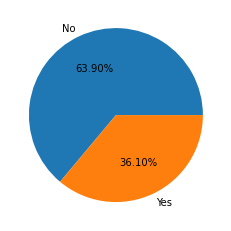

In [223]:
plt.pie(df.Recommended.value_counts(),autopct='%.2f%%',labels=['No','Yes']);
recommend = df.Recommended.value_counts(normalize=True).reset_index()
recommend.to_csv('data/recommend.csv',index=False)
recommend

We see that ~63% of people would not recommend the airline.

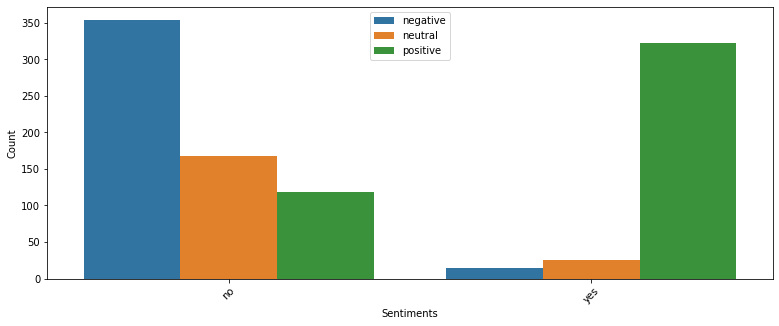

In [152]:
fig = plt.figure(figsize=(13,5))
sns.countplot(x=df['Recommended'], hue=sentiments)
plt.xticks(rotation=45)
plt.xlabel('Sentiments')
plt.ylabel('Count');

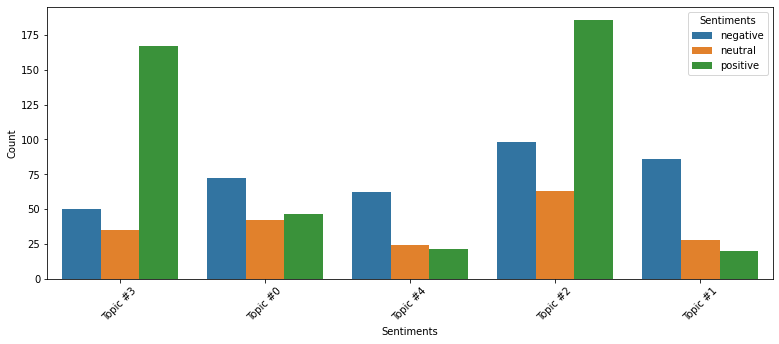

In [154]:
fig = plt.figure(figsize=(13,5))
sns.countplot(data=df,hue='review_sentiments', x='Predicted Topic')
plt.xticks(rotation=45)
plt.xlabel('Sentiments')
plt.legend(title='Sentiments')
plt.ylabel('Count');